In [2]:
import numpy as np
from numpy.random import normal
import mpmath as mp

b = 1.0
T = 3.0

# Closed formula
x = b * b / (2 * T)
true_E = T * (1 - 1 / np.sqrt(np.pi) * mp.gammainc(0.5, x)) + b * b / (2 * np.sqrt(np.pi))  * mp.gammainc(-0.5, x)
print('true E:', true_E)

# We use the same samples for all computations to "cancel" the variance effect
# Maximum number of timesteps
nTimeSteps = 500
nSamples = 500000
dB = normal(0, 1, (nSamples, nTimeSteps)) * np.sqrt(T / nTimeSteps)
B = np.cumsum(dB, axis=1)
B[:, -1] = b # Pin the value at time T



true E: 1.91500648773335


In [18]:
def crude_Etau(nDates):
    crudeB = np.empty((nSamples, nDates))
    offset = int(nTimeSteps / nDates)
    crudeB = B[:, range(offset - 1, nTimeSteps, offset)]
    crudeTau = (np.argmax(crudeB >= b, axis=1) + 1) * T / nDates
    crude_E = np.mean(crudeTau)
    return crude_E - float(true_E)

def refine_tau_sampling(B:list[float], T:float, barrier:float, nDates:int, nSubTicks:int, threshold: int):
    """Refine the crude estimate of the hitting time whenever the value of |B_t - barrier| is less than threshold. 

    Args:
        B: A discretization of the Brownian motion on ]0,T] with nDates. The value at time 0 is NOT included
        T: maturity
        nDates: Number of discretization points
        nSubTicks: Number of subticks for each discretization point when B_t is close to the barrier
        threshold: Used to determine when to refine the estimate
    """
    for i in range(len(B)):
        t = i * T / nDates
        Bt = B[i]
        if abs(Bt - barrier) < threshold:
            Btj = Bt
            for j in range(nSubTicks):
                dB = normal(0, 1) * np.sqrt(T / nDates / nSubTicks)
                Btj += dB
                if Btj > barrier:
                    return t + j * T / nDates / nSubTicks
    return (np.argmax(B >= b) + 1) * T / nDates

def refine_Etau(nDates, nSubTicks, threshold):
    crudeB = np.empty((nSamples, nDates))
    offset = int(nTimeSteps / nDates)
    crudeB = B[:, range(offset - 1, nTimeSteps, offset)]
    refinedTau = np.empty(nSamples)
    isCloseToBarrier = np.any(np.abs(crudeB[:, :-1] - b) < threshold, axis=1)
    refinedTau[~isCloseToBarrier] = (np.argmax(crudeB[~isCloseToBarrier] >= b, axis=1) + 1) * T / nDates
    refinedTau[isCloseToBarrier] = list(map(lambda B: refine_tau_sampling(B, T, b, nDates, nSubTicks, threshold), crudeB[isCloseToBarrier]))
    refined_E = np.mean(refinedTau)
    return refined_E - float(true_E)

In [19]:
refine_Etau(10, 4, 0.1)

0.343930062266645

In [13]:
crude_Etau(10)

0.3631827122666458

In [5]:
dates = [10, 20, 50, 100, 125, 250, 500]
tau1 = [crude_Etau(d) for d in dates]
tau2 = [refine_Etau(d, 4, 0.1) for d in dates]
print(tau1)
print(tau2)

[0.3631827122666458, 0.26263321226664527, 0.16877443226664512, 0.11944999226664521, 0.10762096826664491, 0.07592030426664564, 0.05321581226664596]
[0.3451329122666458, 0.2832239372666443, 0.16638394226664577, 0.08075387726664607, 0.05928759626664526, 0.011497734266645576, -0.011797295733355195]


Ordre de la méthode naive: [-0.49073001]
Ordre de la méthode conditionnelle: [-0.96965705]


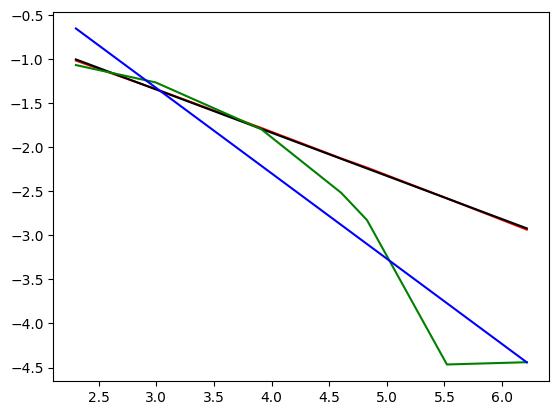

In [6]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def regress(dates, tau):
    log_dates = np.log(np.reshape(dates, (-1, 1)))
    reg = LinearRegression().fit(log_dates, np.log(tau))
    return reg

log_dates = np.log(np.reshape(dates, (-1, 1)))


reg = regress(dates, tau1)
print(f'Ordre de la méthode naive: {reg.coef_}')
plt.plot(log_dates, np.log(tau1), color='red')
plt.plot(log_dates, reg.predict(log_dates), color='black')

tau2 = np.abs(tau2)
reg = regress(dates, tau2)
print(f'Ordre de la méthode conditionnelle: {reg.coef_}')
plt.plot(log_dates, np.log(tau2), color='green')
plt.plot(log_dates, reg.predict(log_dates), color='blue')